In [11]:
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt

from scipy import signal

from mne.time_frequency import psd_array_multitaper

import numpy as np
from sklearn.cross_decomposition import CCA

In [12]:
# Dicionário para armazenar os dados
original = {}

# Path para o file com os dados
directory = "Data_trials"

# Iterar através de cada pasta de participante
for participant_folder in os.listdir(directory):
    participant_path = os.path.join(directory, participant_folder)
    if os.path.isdir(participant_path):
        participant_number = participant_folder[1:]  # Extrair número do participante do nome da pasta

        # Iterar através dos arquivos MATLAB na pasta do participante
        for file_name in os.listdir(participant_path):
            if file_name.endswith(".mat") and not file_name.endswith(("5.mat", "6.mat")):
                file_path = os.path.join(participant_path, file_name)

                # Carregar arquivo MATLAB
                mat_data = loadmat(file_path)

                # Selecionar a key com o nome do file
                keys = mat_data.keys()
                key = list(keys)[3]

                # Criar DataFrame a partir dos dados; .T para transformar linhas em colunas
                df = pd.DataFrame(mat_data[key].T, columns=['TimeStamps','PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2'])

                # Adicionar os dados ao dicionário usando o nome da variável como chave
                if key not in original:
                    original[key] = []
                original[key].append(df)

#Oz
oz = {}
for key, dfs in original.items():
    oz[key] = []
    for df in dfs:
        oz_data = df['Oz']
        oz[key].append(oz_data)

In [13]:
# Cálculo da frequência de amostragem

data = original['P01_T1_R1_1'][0]
time_diff = data['TimeStamps'].diff().mean()
fs = 1 / time_diff
print("Sampling frequency =", fs, "Hz")

Sampling frequency = 512.0 Hz


In [14]:
num_samples_to_trim = int(0.5 * fs)

for key, dfs in original.items():
    trimmed_dfs = []
    for df in dfs:
        df_trimmed = df.iloc[num_samples_to_trim:-(num_samples_to_trim)].reset_index(drop=True)
        trimmed_dfs.append(df_trimmed)
    original[key] = trimmed_dfs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


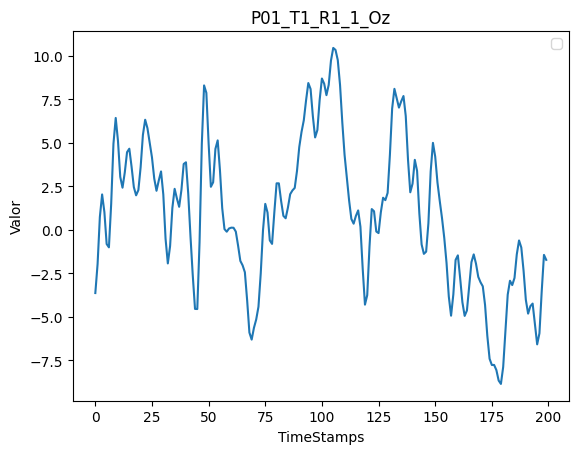

In [15]:
# # Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
# for key, dfs in original.items():
#     if key == "P01_T1_R1_1":
#         plt.title(f'{key}')
#         for data in dfs:
#             data_subset = data.iloc[:200]
#             # Plotar cada estado (relativa a cada coluna)
#             for channel in data.columns[1:]:
#                 plt.plot(data_subset[data.columns[0]], data_subset[channel], label=channel)
#         plt.xlabel('TimeStamps')
#         plt.ylabel('Valor')
#         plt.legend()
#         plt.show()

# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in oz.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}_Oz')
        for data in dfs:
            data_subset = data.iloc[:200]
            plt.plot(data_subset)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

In [16]:
#Definição de parâmetros dos filtros
notch_freq = 50.0 
quality_factor = 40.0
highcut = 20
order = 8
lowcut = 5

#Lowpass & Notch
sos = signal.iirfilter(order, highcut, btype='lowpass', analog=False, ftype='butter', fs=fs, output='sos')
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
b_hp, a_hp = signal.butter(order, lowcut, btype='highpass', fs=fs)

#Dataframe com os dados filtrados
filtrado= {}

#Aplicação do low pass filter
for key, dfs in original.items():
    filtrado[key] = []
    for df in dfs:
        timestamps = df['TimeStamps']
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        df_filtrado_lp = pd.DataFrame(signal.sosfiltfilt(sos, df_without_timestamps.values, axis=0), columns=df_without_timestamps.columns)
        df_filtrado_lphp = pd.DataFrame(signal.filtfilt(b_hp, a_hp, df_filtrado_lp.values, axis=0), columns=df_without_timestamps.columns)
        df_filtrado = pd.concat([timestamps, df_filtrado_lphp], axis=1)
        filtrado[key].append(df_filtrado)

#Aplicação do notch filter
for key, dfs in filtrado.items():
    for df in dfs:
        for column in df.columns[1:]:
            df[column] = signal.filtfilt(b_notch, a_notch, df[column])

#Oz filtrado
oz_filtered = {}
for key, dfs in filtrado.items():
    oz_filtered[key] = []
    for df in dfs:
        oz_filtered_data = df['Oz']
        oz_filtered[key].append(oz_filtered_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


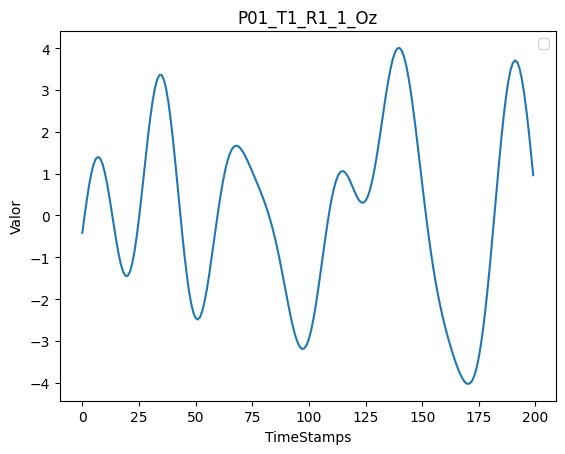

In [17]:
# # Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
# for key, dfs in filtrado.items():
#     if key == "P01_T1_R1_1":
#         plt.title(f'{key}')
#         for data in dfs:
#             data_subset = data.iloc[:200]
#             # Plotar cada estado (relativa a cada coluna)
#             for channel in data.columns[1:]:
#                 plt.plot(data_subset[data.columns[0]], data_subset[channel], label=channel)
#         plt.xlabel('TimeStamps')
#         plt.ylabel('Valor')
#         plt.legend()
#         plt.show()

# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in oz_filtered.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}_Oz')
        for data in dfs:
            data_subset = data.iloc[:200]
            plt.plot(data_subset)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

In [18]:
# oz_concatenated = []

# for key, dfs in oz_filtered.items():
#     for df in dfs:
#         oz_data = df.values
#         oz_concatenated.append(oz_data)
# oz_concatenated = np.concatenate(oz_concatenated)

# print(oz_concatenated.shape)

In [19]:
# from numpy.lib.stride_tricks import sliding_window_view

# # Tamanho da janela = 5 segundos
# window_size = int(fs*4)

# # Passo (quantas amostras a janela avança a cada iteração) = 3 segundos
# step = int(fs*3)

# # Aplicar sliding window ao oz_concatenated
# oz_windows = sliding_window_view(oz_concatenated, window_shape=(window_size,))

# oz_windows = oz_windows[::step]

In [20]:
# # Get the first key (assuming keys represent trial names or similar)
# first_key = list(oz_filtered.keys())[0]
# first_matrix = np.array(oz_filtered[first_key])
# X = first_matrix.T

# # Creating the time series windows
# window_size = X.shape[0] # Assuming you want the same window size as the first matrix's rows
# t = np.linspace(0, 5, window_size, endpoint=False)

# x1_windows = np.sin(2 * np.pi * 7 * t)
# x2_windows = np.sin(2 * np.pi * 11 * t)
# x3_windows = np.sin(2 * np.pi * 13 * t)
# x4_windows = np.sin(2 * np.pi * 17 * t)

# # Stack the window arrays vertically and transpose to create the correct shape
# X_windows = np.vstack([x1_windows, x2_windows, x3_windows, x4_windows]).T

# # Creating an instance of CCA
# cca = CCA(n_components=1)  # Define the number of canonical components

# Correlation = []

# for window in [x1_windows, x2_windows, x3_windows, x4_windows]:
#     # Fitting the CCA to your data
#     cca.fit(X, window)
#     # Transforming the data using the CCA
#     x1, x2  = cca.transform(X, window)
#     corr = np.corrcoef(x1.T, x2.T)[0, 1]
#     Correlation.append(corr)

# print(Correlation)

In [21]:
# Get the first key (assuming keys represent trial names or similar)
first_key = list(oz_filtered.keys())[0]
first_matrix = np.array(oz_filtered[first_key])
X = first_matrix.T

# Creating the time series windows
window_size = X.shape[0] # Assuming you want the same window size as the first matrix's rows
t = np.linspace(0, 4, window_size, endpoint=False)

# x1_windows = 10*np.sin(2 * np.pi * 7 * t)
# x2_windows = 10*np.sin(2 * np.pi * 11 * t)
# x3_windows = 10*np.sin(2 * np.pi * 13 * t)
# x4_windows = 10*np.sin(2 * np.pi * 17 * t)

# # Stack the window arrays vertically and transpose to create the correct shape
# X_windows = np.vstack([x1_windows, x2_windows, x3_windows, x4_windows]).T

# Generating sine and cosine reference signals
frequencies = [7, 11, 13, 17]
reference_signals = []
for freq in frequencies:
    sine_wave = 10 * np.sin(2 * np.pi * freq * t)
    cosine_wave = 10 * np.cos(2 * np.pi * freq * t)
    reference_signals.append(sine_wave)
    reference_signals.append(cosine_wave)

In [22]:
# Função para calcular as correlações
def calculate_correlations(matrix, reference_signals):
    cca = CCA(n_components=1)  # Defina o número de componentes canônicos
    Correlation = []

    for ref_signal in reference_signals:
        # Ajustar o CCA aos dados
        cca.fit(matrix, ref_signal)
        # Transformar os dados usando o CCA
        x1, x2 = cca.transform(matrix, ref_signal)
        corr = np.corrcoef(x1.T, x2.T)[0, 1]
        Correlation.append(corr)
    
    return Correlation

In [23]:
# Iterar sobre todas as chaves em oz_filtered e calcular as correlações
all_correlations = {}

total_correct = 0
total_trials = 0

for key in oz_filtered:
    matrix = np.array(oz_filtered[key]).T
    correlations = calculate_correlations(matrix, reference_signals)
    max_correlation_index = np.argmax(correlations)  # Índice da coluna com o valor máximo
    all_correlations[key] = {'correlations': correlations, 'max_correlation_index': max_correlation_index // 2 + 1}
    
    last_character = key[-1]
    if str(max_correlation_index // 2 +1) == last_character:  # Comparar com o último caractere
        total_correct += 1
    total_trials += 1

# Calcular a accuracy
accuracy = total_correct / total_trials

# Exibir as correlações
for key, correlations in all_correlations.items():
    print(f"{key}: {all_correlations[key]}")

print(f"Total de trials: {total_trials}")
print(f"Total de respostas corretas: {total_correct}")
print(f"Accuracy: {accuracy * 100:.2f}%")

P01_T1_R1_1: {'correlations': [0.07873552548978892, 0.24572077042097865, 0.050539615514964296, 0.044823030194229, 0.02983437932895889, 0.06588036282438874, 0.01910914400878349, 0.12262697802644563], 'max_correlation_index': 1}
P01_T1_R1_2: {'correlations': [0.11527018539779102, 0.1855094646202845, 0.43534789636020776, 0.003846546679671236, 0.004058807762967281, 0.12555671336932925, 0.0205155435634008, 0.0991715323629148], 'max_correlation_index': 2}
P01_T1_R1_3: {'correlations': [0.02112755863363611, 0.056270782536964735, 0.021248748278864044, 0.22433346092619774, 0.04537778882749851, 0.4143046207674837, 0.04229888925241817, 0.06472921484229131], 'max_correlation_index': 3}
P01_T1_R1_4: {'correlations': [0.022153039512884574, 0.0017929990278142626, 0.0031269764416414518, 0.03149908588024445, 0.07486429499134481, 0.0424407816874599, 0.04672444153416677, 0.2721959818081454], 'max_correlation_index': 4}
P01_T1_R2_1: {'correlations': [0.11634147547657324, 0.04793075770430964, 0.04293806991